In [1]:
import pandas as pd
from pathlib import Path # 统一路径，文件管理
mypath = Path(".")

## 数据描述

In [2]:
df = pd.read_csv(mypath/'dianping.csv')
# 这一步加载很慢

In [4]:
df.head()

,comment,sentiment
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0
1,菜品丰富质量好，服务也不错！很喜欢！,1
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,1
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,1


In [6]:
df['sentiment'].value_counts().to_frame()

,sentiment
1,1000
0,1000


## 分词

In [7]:
# !pip install jieba

In [8]:
import jieba

In [10]:
df['text'] = df['comment'].apply(lambda x: " ".join(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIJIAX~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.334 seconds.
Prefix dict has been built succesfully.


分词时间会很长。

In [11]:
df.head()

,comment,sentiment,text
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0,口味 ： 不 知道 是 我口 高 了 ， 还是 这家 真 不怎么样 。 我 感觉 口味 ...
1,菜品丰富质量好，服务也不错！很喜欢！,1,菜品 丰富 质量 好 ， 服务 也 不错 ！ 很 喜欢 ！
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0,说真的 ， 不 晓得 有人 排队 的 理由 ， 香精 香精 香精 香精 ， 拜拜 ！
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,1,菜量 实惠 ， 上菜 还 算 比较 快 ， 疙瘩汤 喝出 了 秋日 的 暖意 ， 烧茄子 吃...
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,1,先说 我 算是 娜娜 家风 荷园 开业 就 一直 在 这里 吃 每次 出去 回来 总想 ...


In [12]:
df.to_csv(mypath/"output/dianping_cut.csv")

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [14]:
maxlen = 100 # 句子最大长度
max_words = 10000 # 词向量的词的最大数目，越大越精确

In [15]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)

In [16]:
type(sequences)
len(sequences[0])

150

In [17]:
[len(sequence) for sequence in sequences[:5]]

[150, 12, 16, 57, 253]

In [18]:
data = pad_sequences(sequences, maxlen=maxlen, value = 0.0)

In [19]:
[len(sequence) for sequence in data[:5]]

[100, 100, 100, 100, 100]

长句子被剪裁(`maxlen`)，短句子被 0 padding

In [20]:
print(data.shape)
print(maxlen)

(2000, 100)
100


In [21]:
word_index = tokenizer.word_index

In [22]:
type(word_index)

dict

In [23]:
[str(key)+": "+str(value) for key, value in word_index.items()][:5]

['，: 1', '的: 2', '了: 3', '。: 4', '\xa0: 5']

## encoding

In [25]:
indices = np.arange(data.shape[0]) # 起始随机状态
np.random.shuffle(indices)

In [92]:
labels = df['sentiment']

In [93]:
labels.head()

0    0
1    1
2    0
3    1
4    1
Name: sentiment, dtype: int64

In [28]:
data = data[indices] # 特征变量-词向量
labels = labels[indices] # 多分类标签

In [29]:
training_samples = int(len(indices) * .8)
validation_samples = len(indices) - training_samples

In [30]:
print(training_samples, validation_samples)

1600 400


## 训练集和测试集切分

In [31]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

`training_samples: training_samples + validation_samples`等于从`training_samples`到`training_samples + validation_samples`

In [45]:
# Wide feature 2: one-hot vector of variety categories
from sklearn.preprocessing import LabelEncoder
import keras

# Use sklearn utility to convert label strings to numbered index

variety_train = data[:training_samples]
variety_test = data[training_samples: training_samples + validation_samples]

# # Convert labels to one hot
# variety_train = keras.utils.to_categorical(variety_train, 10000)
# variety_test = keras.utils.to_categorical(variety_test, 10000)

In [46]:
variety_train.shape

(1600, 100)

In [34]:
X_train[:5,:5]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

## 词向量引入

In [47]:
# !pip install gensim

In [48]:
from gensim.models import KeyedVectors

In [49]:
# myzip = mypath / 'zh.zip'

In [50]:
# !unzip $myzip

In [51]:
zh_model = KeyedVectors.load_word2vec_format(mypath/'zh.vec')

In [52]:
zh_model.vectors.shape

(50102, 300)

In [53]:
zh_model.vectors[0].shape

(300,)

In [54]:
list(iter(zh_model.vocab))[:5]

['的', '</s>', '在', '是', '年']

In [55]:
embedding_dim = len(zh_model[next(iter(zh_model.vocab))])

In [56]:
embedding_dim

300

In [57]:
print('最大值: ',zh_model.vectors.max())
print('最小值: ',zh_model.vectors.min())

最大值:  1.8878
最小值:  -2.1188


In [58]:
embedding_matrix = np.random.uniform(zh_model.vectors.min(), zh_model.vectors.max(), [max_words, embedding_dim])

随机数参考 https://stackoverflow.com/questions/11873741/sampling-random-floats-on-a-range-in-numpy

In [59]:
embedding_matrix = (embedding_matrix - 0.5) * 2

In [60]:
zh_model.get_vector("的").shape

(300,)

In [61]:
zh_model.get_vector("李").shape

(300,)

In [62]:
for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = zh_model.get_vector(word)
            embedding_matrix[i] = embedding_vector
        except:
            pass # 如果无法获得对应的词向量，我们就干脆跳过，使用默认的随机向量。

这也是为什么，我们前面尽量把二者的分布调整成一致。

In [63]:
embedding_matrix.shape

(10000, 300)

参考 https://github.com/chen0040/keras-sentiment-analysis-web-api/blob/master/keras_sentiment_analysis/library/lstm.py

In [64]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, Bidirectional
from keras import layers
import keras

## wide model

In [69]:
variety_inputs = layers.Input(shape=(100,))
merged_layer = layers.Dense(256, activation='relu')(variety_inputs)
predictions = layers.Dense(1, activation='sigmoid')(merged_layer)
wide_model = keras.Model(inputs=variety_inputs, outputs=predictions)

In [70]:
wide_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
print(wide_model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 26,113
Trainable params: 26,113
Non-trainable params: 0
_________________________________________________________________
None


## deep model

In [71]:
embedding_layer = Embedding(input_dim=max_words,
                            output_dim=embedding_dim, 
                            input_length=maxlen,
                            weights=[embedding_matrix], 
                            trainable=False, 
                            name='embedding_layer')
dropout_layer = Dropout(0.2)
i = layers.Input(shape=(maxlen,), dtype='int32', name='main_input')
x = embedding_layer(i)
x = dropout_layer(x)
LSTM_units = 16
x = Bidirectional(LSTM(units=LSTM_units, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_words, embedding_dim)))(x)
x = dropout_layer(x)
# x = Flatten()(x)
o = Dense(1, activation='sigmoid')(x)
deep_model = keras.Model(inputs=i, outputs=o)
print(deep_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 100, 300)     3000000     main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             multiple             0           embedding_layer[0][0]            
                                                                 bidirectional_1[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32)           40576       dropout_1[0][0]            

In [73]:
deep_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# LSTM_units = 16
# deep_model = Sequential()
# deep_model.add(Embedding(max_words, embedding_dim))
# deep_model.add(Dropout(0.2))
# deep_model.add(Bidirectional(LSTM(units=LSTM_units, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_words, embedding_dim))))
# deep_model.add(Dropout(0.2))
# deep_model.add(Dense(25, activation='softmax'))
# deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# deep_model.summary()

In [ ]:
# deep_model.layers[0].set_weights([embedding_matrix])
# deep_model.layers[0].trainable = False # 不跑，用预训练模型。

## 模型合并

In [74]:
# Combine wide and deep into one model
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1, activation='sigmoid')(merged_out)
combined_model = keras.Model([wide_model.input] + [deep_model.input], merged_out)
print(combined_model.summary())

combined_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 100, 300)     3000000     main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             multiple             0           embedding_layer[0][0]            
                                                                 bidirectional_1[0][0]            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                      

In [77]:
# Run training
history = combined_model.fit([variety_train] + [X_train], y_train, epochs=20, batch_size=32, 
                   validation_data=([variety_test] + [X_valid], y_valid))

# 有监督的学习
combined_model.save(mypath/"output/binary_classification-wide_and_deep-v.1.0.0.h5")

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 6s 4ms/step - loss: 0.8279 - acc: 0.5038 - val_loss: 0.8192 - val_acc: 0.5075
Epoch 2/20
1600/1600 [==============================] - 5s 3ms/step - loss: 0.8164 - acc: 0.5031 - val_loss: 0.8013 - val_acc: 0.5075
Epoch 3/20
1600/1600 [==============================] - 5s 3ms/step - loss: 0.7974 - acc: 0.5050 - val_loss: 0.7798 - val_acc: 0.5150
Epoch 4/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.7798 - acc: 0.5044 - val_loss: 0.7629 - val_acc: 0.5150
Epoch 5/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.7625 - acc: 0.5044 - val_loss: 0.7479 - val_acc: 0.5150
Epoch 6/20
1600/1600 [==============================] - 4s 3ms/step - loss: 0.7486 - acc: 0.5044 - val_loss: 0.7355 - val_acc: 0.5150
Epoch 7/20
1600/1600 [==============================] - 5s 3ms/step - loss: 0.7354 - acc: 0.5044 - val_loss: 0.7241 - val_acc: 0.5150
Epoch 8/20
1600

模型融合后并不理想。

In [79]:
accr = combined_model.evaluate([variety_train] + [X_train], y_train)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = combined_model.evaluate([variety_test] + [X_valid], y_valid)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1600/1600 [==============================] - 1s 808us/step
Test set
  Loss: 0.685
  Accuracy: 0.601
400/400 [==============================] - 0s 915us/step
Test set
  Loss: 0.690
  Accuracy: 0.515


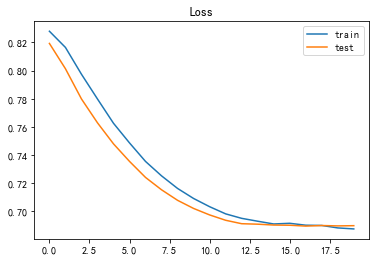

In [82]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## 预测

In [83]:
data.shape

(2000, 100)

In [84]:
np_pred = combined_model.predict([data]+[data])

In [85]:
np_pred.__class__

numpy.ndarray

In [87]:
np.save(mypath/"output/dianping_pred",  np_pred) # 很快

In [88]:
np_pred.shape

(2000, 1)

In [94]:
output = pd.concat([
    df.iloc[indices],
    pd.DataFrame({
        'y': labels,
        'yhat': pd.DataFrame(np_pred).idxmax(1)
    })],
    axis = 1
)

In [96]:
output.head()

,comment,sentiment,text,y,yhat
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,0,口味 ： 不 知道 是 我口 高 了 ， 还是 这家 真 不怎么样 。 我 感觉 口味 ...,0,0
1,菜品丰富质量好，服务也不错！很喜欢！,1,菜品 丰富 质量 好 ， 服务 也 不错 ！ 很 喜欢 ！,1,0
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,0,说真的 ， 不 晓得 有人 排队 的 理由 ， 香精 香精 香精 香精 ， 拜拜 ！,0,0
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,1,菜量 实惠 ， 上菜 还 算 比较 快 ， 疙瘩汤 喝出 了 秋日 的 暖意 ， 烧茄子 吃...,1,0
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,1,先说 我 算是 娜娜 家风 荷园 开业 就 一直 在 这里 吃 每次 出去 回来 总想 ...,1,0


In [97]:
output.to_csv(mypath/"output/dianping_pred.csv", index = False, encoding = "UTF-8")

## 效果可视化

In [98]:
pd.DataFrame(np_pred[0:10]).round(2)

,0
0,0.52
1,0.51
2,0.48
3,0.51
4,0.47
5,0.49
6,0.51
7,0.48
8,0.49
9,0.49


In [99]:
pd.DataFrame(labels[0:10])

,sentiment
0,0
1,1
2,0
3,1
4,1
5,1
6,1
7,1
8,1
9,1


查看这五个样本还是很准的。